In [1]:
import os
import sys
import inspect

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, fixed

In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
print(f"{parent_dir} was added to sys.path")

/Users/g.gospodinov/Desktop/IntTool was added to sys.path


In [3]:
from IntTool.utils import *

In [4]:
def interferogram_describe(interferogram, mask_size, area_to_show, gauss_mask=False, shift_x=800, shift_y=1200):
    plt.imshow(interferogram, cmap='gray')
    plt.title('interferogram')
    plt.axis('off')
    plt.show()

    spectrum = complex_abs(fourier(interferogram))

    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.imshow(np.log(spectrum), cmap='jet')
    plt.title('spectrum')

    shifted_spectrum = spectrum[:shift_y, :shift_x]

    plt.subplot(132)
    plt.imshow(np.log(shifted_spectrum), cmap='jet')
    plt.title('shifted spectrum')

    max_id = np.array(np.unravel_index(shifted_spectrum.argmax(), shifted_spectrum.shape))

    plt.subplot(133)
    plt.imshow(
        np.log(spectrum[
            max_id[0] - area_to_show[0]: max_id[0] + area_to_show[0] + 1,
            max_id[1] - area_to_show[1]: max_id[1] + area_to_show[1] + 1
        ]),
        cmap='jet'
    )
    plt.title('detected maximum')
    plt.show()

    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.imshow(
        apply_mask(np.log(spectrum), max_id, mask_size, complex_mask=False, gauss=gauss_mask)[
            max_id[0] - area_to_show[0]: max_id[0] + area_to_show[0] + 1,
            max_id[1] - area_to_show[1]: max_id[1] + area_to_show[1] + 1
        ],
        cmap='jet'
    )
    plt.title('maximum with filter')

    plt.subplot(132)
    plt.imshow(
        apply_mask(
            np.log(spectrum),
            max_id, 
            mask_size, 
            complex_mask=False, 
            gauss=gauss_mask
        ),
        cmap='jet'
    )
    plt.title('spectrum with mask')

    plt.subplot(133)
    plt.imshow(
        complex_abs(
            inverse_fourier(apply_mask(fourier(interferogram), max_id, mask_size, gauss=gauss_mask))
        ),
        cmap='gray')
    plt.title('Inverse fourier after mask')
    plt.axis('off')
    plt.show()
    
    return max_id

In [5]:
wavelength = 0.4 # mkm

pixel_size = 5.86 # mkm
test_obj_mkm_size = 230 # mkm
test_obj_pix_size = 243 # pix
magnification = test_obj_pix_size * pixel_size / test_obj_mkm_size
print('magnification =', magnification)
mkm_per_pixel = pixel_size / magnification

print('mkm_per_pixel =', mkm_per_pixel)

magnification = 6.191217391304348
mkm_per_pixel = 0.9465020576131687


In [6]:
IN_FOLDER = './data_to_prepare/'
OUT_FOLDER = './prepared_data/'
back_name = 'bg.png'
int_name = 'int.png'

delay_folder = input('delay_folder: ')

IN_PATH = os.path.join(IN_FOLDER, delay_folder)
OUT_PATH = os.path.join(OUT_FOLDER, delay_folder)

if not os.path.exists(OUT_FOLDER):
    os.mkdir(OUT_FOLDER)

if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

delay_folder: 0ns


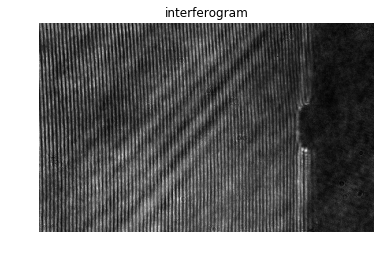

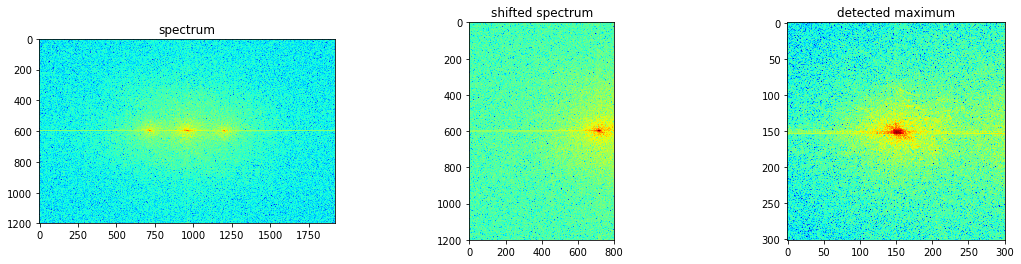

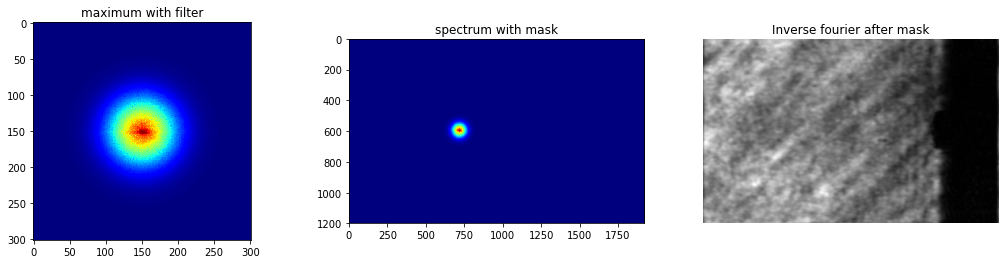

In [7]:
interferogram = read_image(os.path.join(IN_PATH, int_name))
background = read_image(os.path.join(IN_PATH, back_name))

mask_size = (1050, 1050)
area_to_show = (150, 150)
gauss_mask = True

mask_center = interferogram_describe(interferogram, mask_size, area_to_show, gauss_mask=gauss_mask)

In [8]:
mask = []
target_position = 0
x = np.arange(interferogram.shape[1])
y = np.arange(interferogram.shape[0])

@interact(img=fixed(interferogram),
          x1 = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=False, value=1000),
          x2 = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=False, value=1490),
          y1 = IntSlider(min=y[0], max=y[-1], step=10, continuous_update=False, value=150),
          y2 = IntSlider(min=y[0], max=y[-1], step=10, continuous_update=False, value=1000),
          target = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=False, value=1570),
          color=fixed('red'),
          target_color=fixed('green')
         )
def search_mask(img, x1, x2, y1, y2, target, color, target_color):
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap='gray', vmin=img.min() * 1.5, vmax=img.max() * 0.7)
    plt.plot([x1, x1], [0, img.shape[0] - 1], color)
    plt.plot([x2, x2], [0, img.shape[0] - 1], color)
    plt.plot([0, img.shape[1] - 1], [y1, y1], color)
    plt.plot([0, img.shape[1] - 1], [y2, y2], color)
    plt.plot([target, target], [0, img.shape[0] - 1], target_color)
    plt.savefig(os.path.join(OUT_PATH,'./crop_position_{}.png'.format(delay_folder)))
    plt.show()
    Intensity = complex_abs(
        inverse_fourier(
            apply_mask(fourier(interferogram), mask_center, mask_size, gauss=gauss_mask)
        )
    )
    plt.figure(figsize=(20, 10))
    plt.imshow(Intensity, cmap='gray')
    plt.plot([x1, x1], [0, Intensity.shape[0] - 1], color)
    plt.plot([x2, x2], [0, Intensity.shape[0] - 1], color)
    plt.plot([0, Intensity.shape[1] - 1], [y1, y1], color)
    plt.plot([0, Intensity.shape[1] - 1], [y2, y2], color)
    plt.plot([target, target], [0, img.shape[0] - 1], target_color)
    plt.show()
    global mask
    mask = [y1, y2, x1, x2]
    global target_position
    target_position = target

interactive(children=(IntSlider(value=1000, continuous_update=False, description='x1', max=1919, step=10), Int…

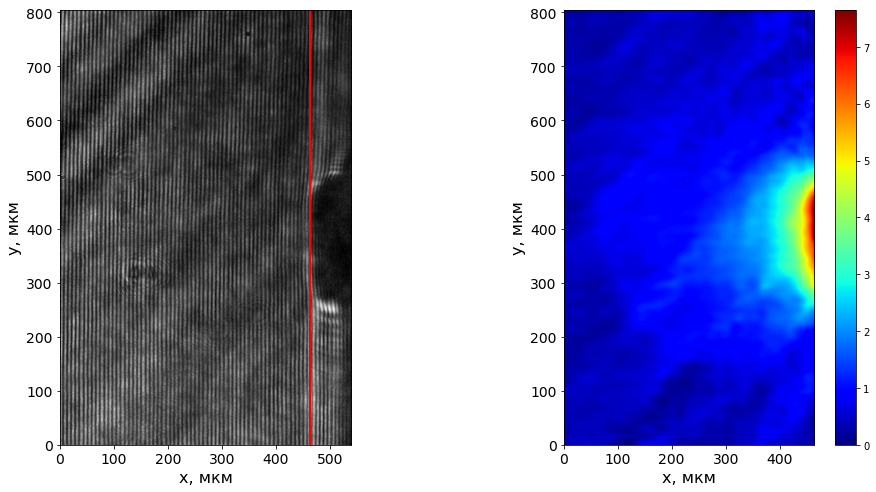

In [9]:
y1,y2,x1,x2 = mask

img_phase = phase(
    inverse_fourier(
        apply_mask(
            fourier(interferogram),
            mask_center, 
            mask_size, 
            gauss=gauss_mask
        )
    )
)[y1:y2, x1:x2]
back_phase = phase(
    inverse_fourier(
        apply_mask(
            fourier(background),
            mask_center, 
            mask_size, 
            gauss=gauss_mask
        )
    )
)[y1:y2, x1:x2]

wrapped_phase = back_phase - img_phase
reconstructed_phase = unwrap_phase(wrapped_phase)
reconstructed_phase -= reconstructed_phase.min()
cleared_phase = reconstructed_phase #- reconstructed_phase[-10:].mean(0)
cleared_phase -= cleared_phase.min()


crop_position = (x2 - x1) * mkm_per_pixel
int_frame = interferogram[y1:y2, x1:target_position]

plt.imshow(
    int_frame, 
    cmap='gray', 
    extent=[0, (target_position - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel]
)
plt.xlabel(u'x, мкм', fontsize=12)
plt.ylabel(u'y, мкм', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axis("off")
plt.savefig(
    os.path.join(OUT_PATH, './interferogram_{}.png'.format(delay_folder)),
    dpi=200,
    bbox_inches='tight',
    pad_inches=0
)
plt.close()

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(int_frame, cmap='gray', extent=[0, (target_position - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel])
plt.plot([crop_position, crop_position], [0, (int_frame.shape[0] - 1) * mkm_per_pixel], color='red', linewidth=2)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(cleared_phase, cmap='jet', extent=[0, (x2 - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel])
plt.colorbar()
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(OUT_PATH, './int_vs_phase_{}.png'.format(delay_folder)), dpi=200)
plt.show()

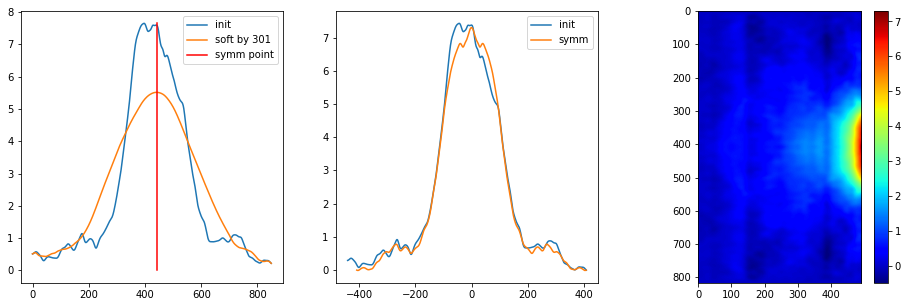

In [10]:
avg_points = 301

# cleared_phase = np.array([soft(cleared_phase[:, i], n=15) for i in range(cleared_phase.shape[1])]).T

center_index=soft(cleared_phase[:, -1], n=avg_points).argmax()
centered = symmetrize(cleared_phase[:, -1], center_index)
phase_x = np.arange(cleared_phase[:, -1].size) - center_index
centered_phase_x = np.arange(centered.size) - centered.size / 2
symmetrical_phase = symmetrize_2d(cleared_phase, center_index)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(cleared_phase[:,-1], label='init')
plt.plot(soft(cleared_phase[:, -1], n=avg_points), label='soft by {}'.format(avg_points))
plt.plot([center_index, center_index], [0, np.max(cleared_phase[:,-1])], 'red', label='symm point')
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(phase_x, cleared_phase[:, -1] - cleared_phase[:, -1].min(), label='init')
plt.plot(centered_phase_x, symmetrical_phase[:, -1], label='symm')
plt.legend()

plt.subplot(1, 3, 3)
plt.imshow(symmetrical_phase, cmap='jet')
plt.colorbar()
plt.show()

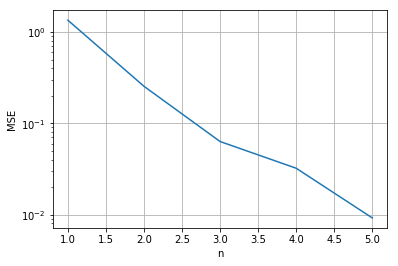

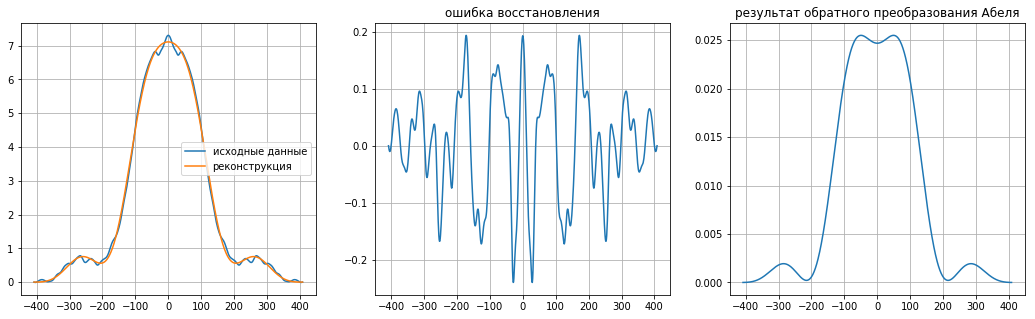

100%|██████████| 490/490 [00:06<00:00, 70.32it/s]


In [11]:
f_r = abel_inversion_2d(symmetrical_phase, n_max=5)#, two_gauss=True, verbose=False, p0=[-150, 20, 50, 150, 20, 50])

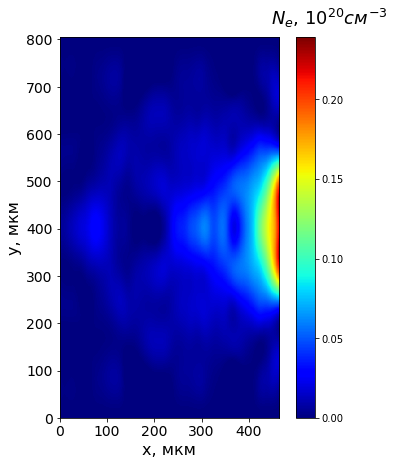

In [12]:
ne = ((1 - (1 - f_r * wavelength / (2 * np.pi * mkm_per_pixel))**2) * critical_density(wavelength) / 1e20)

plt.figure(figsize=(6, 7))
plt.imshow(
    ne, 
    clim=(0, np.max(ne)),
    cmap='jet', 
    extent=(0,(x2-x1)*mkm_per_pixel,0,(y2-y1)*mkm_per_pixel)
)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.set_label(r'$N_e$' + r', ' + r'$10^{20} см^{-3}$', rotation=0, labelpad=-15, y=1.08, fontsize=18)
plt.savefig(os.path.join(OUT_PATH, './ne_10x20_{}.png'.format(delay_folder)), format='png', dpi=200)
plt.show()

In [13]:
with open(os.path.join(OUT_PATH, 'Ne(z) {}.dat'.format(delay_folder)), 'wt') as out_z:
    for k in range(ne.shape[1]):
        out_z.write(
            str((target_position - x2 + k) * mkm_per_pixel) + '\t' + str(ne[ne.shape[0] // 2, ne.shape[1] - k - 1]) + '\n'
        )
with open(os.path.join(OUT_PATH, 'Ne(x) {}.dat'.format(delay_folder)), 'wt') as out_x:
    for k in range(ne.shape[0]):
        out_x.write(str((k - ne.shape[0]//2) * mkm_per_pixel) + '\t' + str(ne[k, ne.shape[1] - 1]) + '\n')
